In [1]:
import pandas as pd
from os.path import join, dirname, basename
import os
import numpy as np
from icecream import ic

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
top_n = 6

In [3]:

indir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/data/clone_var/variants.init_knnRes.30_objs_standard/aggregate/annotation/"
outdir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04/data/clone_var/variants.init_knnRes.30_objs_standard/aggregate/annotation/clone_lineage"


In [4]:
cells_meta = pd.read_csv(join(indir, "se_cells_meta.tsv"), sep="\t")
cells_meta

cells_meta = cells_meta[~(cells_meta["run"].isnull())]
cells_meta["run"].unique()



array(['cd34norm', 'CHIP_a1', 'CHIP_b1', 'CHIP_b2'], dtype=object)

## Plot lineage distribution

In [5]:
cells_meta.columns

Index(['orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'total', 'duplicate',
       'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters',
       'cell_id', 'is__cell_barcode', 'TSS_fragments',
       'DNase_sensitive_region_fragments', 'enhancer_region_fragments',
       'promoter_region_fragments', 'on_target_fragments',
       'blacklist_region_fragments', 'peak_region_fragments',
       'peak_region_cutsites', 'proj', 'expID', 'nucleosome_signal',
       'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile',
       'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group',
       'ATAC_snn_res.0.8', 'seurat_clusters', 'nCount_ATAC_log2', 'nCount_RNA',
       'nFeature_RNA', 'Row.names', 'name', 'cluster_labels', 'run', 'donor',
       'condition'],
      dtype='object')

In [6]:
donor_run_meta = cells_meta.loc[~cells_meta[["run", "donor"]].duplicated(), ["run", "donor"]].set_index("donor")
donor_run_meta

,run
donor,
cd34norm_1,cd34norm
cd34norm_2,cd34norm
cd34norm_3,cd34norm
cd34norm_0,cd34norm
CHIP_a1_1,CHIP_a1
CHIP_a1_4,CHIP_a1
CHIP_a1_3,CHIP_a1
CHIP_a1_0,CHIP_a1
CHIP_a1_2,CHIP_a1


In [7]:
clones_df = cells_meta.groupby(["seurat_clusters", "donor", "name", "run"]).size().reset_index().rename({0:"ncells"}, axis=1)
clones_df

clust_order = clones_df.groupby("seurat_clusters").sum().sort_values("ncells")[::-1].index
clust_order

Int64Index([1, 0, 2, 3, 7, 4, 5, 6, 10, 8, 9, 13, 11, 14, 16, 12, 15, 17, 18], dtype='int64', name='seurat_clusters')

In [8]:
(clones_df["ncells"]<0).any()

False

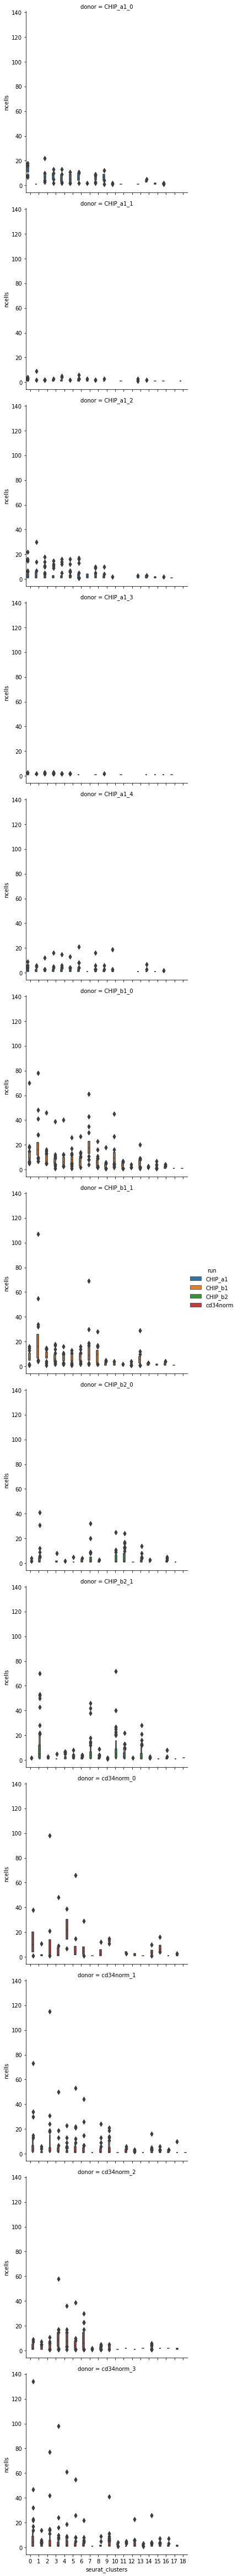

In [9]:
sns.catplot(x="seurat_clusters", y="ncells", data=clones_df, hue="run", 
            row="donor", kind="boxen", )
plt.savefig(join(outdir, "clone_cluster_boxen.svg"))
plt.savefig(join(outdir, "clone_cluster_boxen.pdf"))

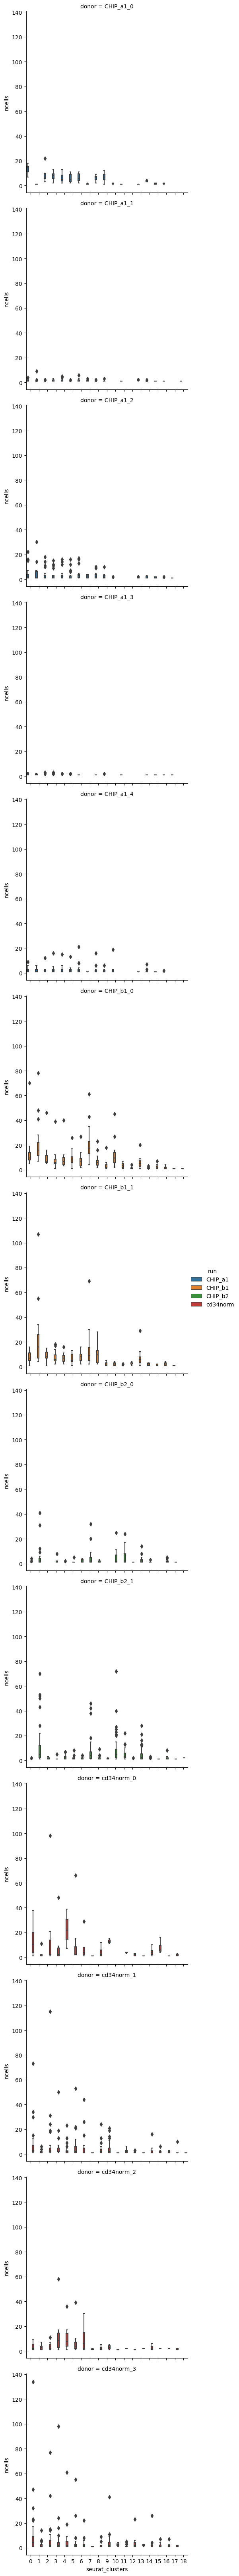

In [10]:
sns.catplot(x="seurat_clusters", y="ncells", data=clones_df, hue="run", 
            row="donor", kind="box")
plt.savefig(join(outdir, "clone_cluster_box.svg"))
plt.savefig(join(outdir, "clone_cluster_box.pdf"))

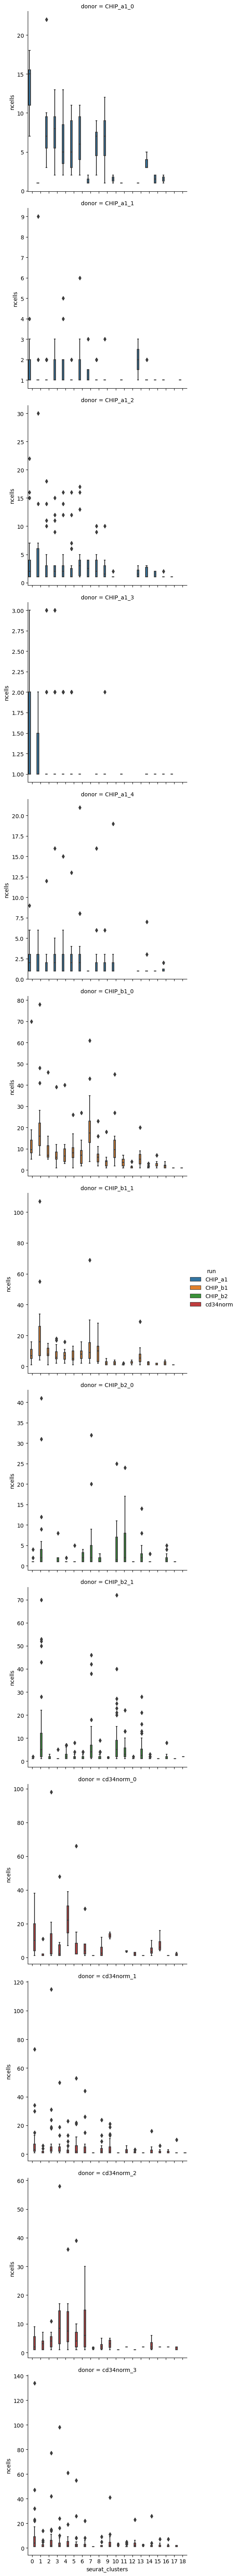

In [12]:
sns.catplot(x="seurat_clusters", y="ncells", data=clones_df, hue="run", 
            row="donor", kind="box", sharey=False)
plt.savefig(join(outdir, "clone_cluster_box_noShareY.svg"))
plt.savefig(join(outdir, "clone_cluster_box.noShareY.pdf"))

In [ ]:
#def plot_top_ncells(data)

In [13]:
clones_df = cells_meta.groupby(["seurat_clusters", "donor", "name", "run", "condition"]).size().reset_index().rename({0:"ncells"}, axis=1)
clust_order = clones_df.groupby("seurat_clusters").sum().sort_values("ncells")[::-1].index
for don, val in clones_df.groupby("donor"):
    top_vals = val.sort_values("ncells")[::-1][:top_n]
    sns.catplot(x="seurat_clusters", y="ncells", data=val, hue="condition", 
                sharex=True, sharey=False, 
                col="name", col_wrap=3, kind="bar", order=clust_order)
    plt.savefig(join(outdir, "topClones_across_lineage.pdf"))
    plt.savefig(join(outdir, "topClones_across_lineage.svg"))
    plt.close()
    
    sns.catplot(x="seurat_clusters", y="ncells", data=val, hue="condition", 
                sharex=False, sharey=False, 
                col="name", col_wrap=3, kind="bar", order=clust_order)
    plt.savefig(join(outdir, "topClones_across_lineage_diffOrder.pdf"))
    plt.savefig(join(outdir, "topClones_across_lineage_diffOrder.svg"))
    plt.close()